In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load CSV data
data = pd.read_csv('new_dataset.csv')

# Fill missing data
data.fillna(method='ffill', inplace=True)

# Feature Engineering for Heat Index (Real-Feel Temperature)
data['heat_index'] = 0.5 * (data['t2m'] + data['d2m'])

# Target variables for each task
y_storm_event = data['tp']  # Total precipitation for storm event prediction
y_heat_index = data['heat_index']  # For heat index prediction
y_drought = data['e']  # Evaporation for drought index prediction
y_climate_pattern = data['t2m']  # Using temperature for climate pattern detection

# Prepare data for ARIMA - Make sure data is stationary
def prepare_data_for_arima(series):
    series = series.dropna()
    return series

# Prepare target variables
y_storm_event = prepare_data_for_arima(y_storm_event)
y_heat_index = prepare_data_for_arima(y_heat_index)
y_drought = prepare_data_for_arima(y_drought)
y_climate_pattern = prepare_data_for_arima(y_climate_pattern)

# Define ARIMA model function
def fit_arima_model(y, order=(1, 1, 1)):
    model = sm.tsa.ARIMA(y, order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

# Fit models for each task
print("Storm Event Prediction:")
storm_model = fit_arima_model(y_storm_event)

print("\nHeat Index Prediction:")
heat_model = fit_arima_model(y_heat_index)

print("\nDrought Index Prediction:")
drought_model = fit_arima_model(y_drought)

print("\nClimate Pattern Detection:")
climate_model = fit_arima_model(y_climate_pattern)

# Making predictions for the next 10 time steps
steps = 10
storm_predictions = storm_model.forecast(steps=steps)
heat_predictions = heat_model.forecast(steps=steps)
drought_predictions = drought_model.forecast(steps=steps)
climate_predictions = climate_model.forecast(steps=steps)

# Print predictions
print("\nStorm Predictions:", storm_predictions)
print("\nHeat Index Predictions:", heat_predictions)
print("\nDrought Predictions:", drought_predictions)
print("\nClimate Predictions:", climate_predictions)

# Calculate MSE and MAE
# For calculating MSE and MAE, we need to align the predictions with actual values
def calculate_metrics(actual, predictions):
    mse = mean_squared_error(actual[-steps:], predictions)
    mae = mean_absolute_error(actual[-steps:], predictions)
    return mse, mae

# Calculate metrics for each prediction task
storm_mse, storm_mae = calculate_metrics(y_storm_event, storm_predictions)
heat_mse, heat_mae = calculate_metrics(y_heat_index, heat_predictions)
drought_mse, drought_mae = calculate_metrics(y_drought, drought_predictions)
climate_mse, climate_mae = calculate_metrics(y_climate_pattern, climate_predictions)

# Print metrics
print("\nStorm Event Prediction - MSE:", storm_mse, ", MAE:", storm_mae)
print("Heat Index Prediction - MSE:", heat_mse, ", MAE:", heat_mae)
print("Drought Index Prediction - MSE:", drought_mse, ", MAE:", drought_mae)
print("Climate Pattern Detection - MSE:", climate_mse, ", MAE:", climate_mae)




C:\Users\Charu Gupta\AppData\Local\Temp\ipykernel_11040\449334005.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Storm Event Prediction:
                               SARIMAX Results                                
Dep. Variable:                     tp   No. Observations:                91980
Model:                 ARIMA(1, 1, 1)   Log Likelihood              595952.908
Date:                Tue, 15 Oct 2024   AIC                       -1191899.816
Time:                        20:42:46   BIC                       -1191871.528
Sample:                             0   HQIC                      -1191891.198
                              - 91980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -6.878e-09      0.000  -2.73e-05      1.000      -0.000       0.000
ma.L1      -6.879e-09      0.000  -2.73e-05      1.000      -0.000       0.000
sigma2      1.379e-07   7.52

C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             heat_index   No. Observations:                91980
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -273467.544
Date:                Tue, 15 Oct 2024   AIC                         546941.089
Time:                        20:43:05   BIC                         546969.376
Sample:                             0   HQIC                        546949.706
                              - 91980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7761      0.001    651.437      0.000       0.774       0.778
ma.L1         -0.9986      0.000  -5793.944      0.000      -0.999      -0.998
sigma2        22.3849      0.073    305.429      0.0

C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      e   No. Observations:                91980
Model:                 ARIMA(1, 1, 1)   Log Likelihood              781411.019
Date:                Tue, 15 Oct 2024   AIC                       -1562816.038
Time:                        20:43:21   BIC                       -1562787.750
Sample:                             0   HQIC                      -1562807.421
                              - 91980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0   6.82e-22          0      1.000   -1.34e-21    1.34e-21
ma.L1              -0   6.82e-22         -0      1.000   -1.34e-21    1.34e-21
sigma2       2.38e-09   3.15e-12    755.705      0.0

C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    t2m   No. Observations:                91980
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -276892.855
Date:                Tue, 15 Oct 2024   AIC                         553791.710
Time:                        20:43:39   BIC                         553819.998
Sample:                             0   HQIC                        553800.327
                              - 91980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7996      0.001    634.249      0.000       0.797       0.802
ma.L1         -0.9985      0.000  -5911.861      0.000      -0.999      -0.998
sigma2        24.1155      0.079    304.938      0.0

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import joblib
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = 'new_dataset.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Convert valid_time to datetime
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Set valid_time as index
data.set_index('valid_time', inplace=True)

# Resampling to daily frequency and taking the mean (adjust as needed)
daily_data = data.resample('D').mean()

# 1. Storm Event Prediction
storm_data = daily_data[['u10', 'v10', 'sp', 'tp']].dropna()
storm_model = ARIMA(storm_data['tp'], order=(5, 1, 0))  # Adjust order as needed
storm_fit = storm_model.fit()

# Save the storm model
joblib.dump(storm_fit, 'storm_event_prediction_model.pkl')

# Calculate MSE for Storm Event Prediction
storm_predictions = storm_fit.predict(start=len(storm_data)-30, end=len(storm_data)-1)  # Last 30 days for testing
mse_storm = mean_squared_error(storm_data['tp'][-30:], storm_predictions)
print(f"Storm Event Prediction MSE: {mse_storm}")

# 2. Heat Index Prediction
# Calculate Humidity from dew point using an approximation formula
daily_data['humidity'] = 100 * (np.exp((17.625 * daily_data['d2m']) / (243.04 + daily_data['d2m'])) /
                                  (np.exp((17.625 * daily_data['t2m']) / (243.04 + daily_data['t2m']))))
heat_index_data = daily_data[['t2m', 'humidity']].dropna()

# Define heat index calculation
def calculate_heat_index(temp, humidity):
    HI = (temp * 9/5) + 32  # Convert Celsius to Fahrenheit
    HI = HI + (0.5 * (1 - humidity / 100) * (HI - 58))
    return (HI - 32) * 5/9  # Convert back to Celsius

heat_index_data['heat_index'] = calculate_heat_index(heat_index_data['t2m'], heat_index_data['humidity'])
heat_index_model = ARIMA(heat_index_data['heat_index'], order=(5, 1, 0))
heat_index_fit = heat_index_model.fit()

# Save the heat index model
joblib.dump(heat_index_fit, 'heat_index_prediction_model.pkl')

# Calculate MSE for Heat Index Prediction
heat_index_predictions = heat_index_fit.predict(start=len(heat_index_data)-30, end=len(heat_index_data)-1)
mse_heat_index = mean_squared_error(heat_index_data['heat_index'][-30:], heat_index_predictions)
print(f"Heat Index Prediction MSE: {mse_heat_index}")

# 3. Climate Pattern Detection
climate_data = daily_data[['z', 'u10', 't2m']].dropna()  # Geopotential height, wind speed, and temperature
climate_model = ARIMA(climate_data['t2m'], order=(5, 1, 0))
climate_fit = climate_model.fit()

# Save the climate pattern detection model
joblib.dump(climate_fit, 'climate_pattern_detection_model.pkl')

# Calculate MSE for Climate Pattern Detection
climate_predictions = climate_fit.predict(start=len(climate_data)-30, end=len(climate_data)-1)
mse_climate = mean_squared_error(climate_data['t2m'][-30:], climate_predictions)
print(f"Climate Pattern Detection MSE: {mse_climate}")

# 4. Drought Index Prediction
drought_data = daily_data[['tp', 'e']].dropna()
drought_data['drought_index'] = drought_data['e'] - drought_data['tp']  # Simplified drought index calculation
drought_model = ARIMA(drought_data['drought_index'], order=(5, 1, 0))
drought_fit = drought_model.fit()

# Save the drought index model
joblib.dump(drought_fit, 'drought_index_prediction_model.pkl')

# Calculate MSE for Drought Index Prediction
drought_predictions = drought_fit.predict(start=len(drought_data)-30, end=len(drought_data)-1)
mse_drought = mean_squared_error(drought_data['drought_index'][-30:], drought_predictions)
print(f"Drought Index Prediction MSE: {mse_drought}")



Storm Event Prediction MSE: 2.513982675443497e-10
Heat Index Prediction MSE: 3.704849075432763
Climate Pattern Detection MSE: 0.4095660971524278
Drought Index Prediction MSE: 2.1275799227706516e-10
All models have been fitted, saved, and MSE calculated successfully.


C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE for tp: 1.0405798830389344e-09


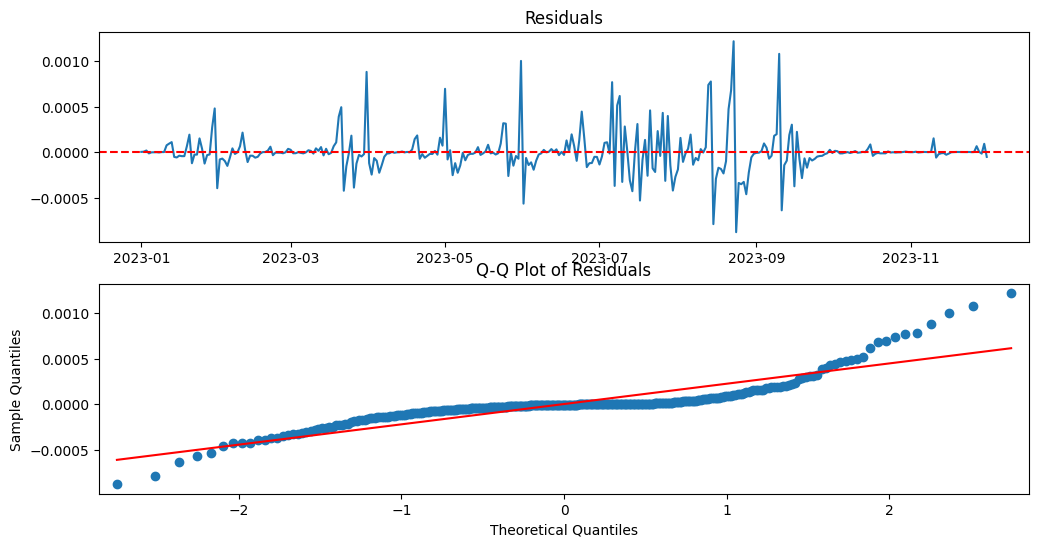

MSE for heat_index: 6.991118110982245


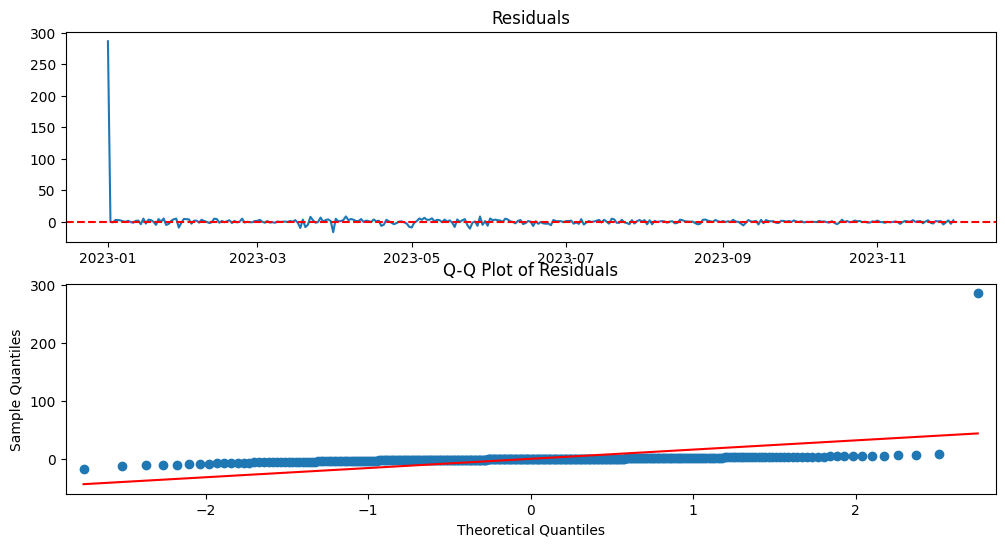

MSE for t2m: 7.397745550964685


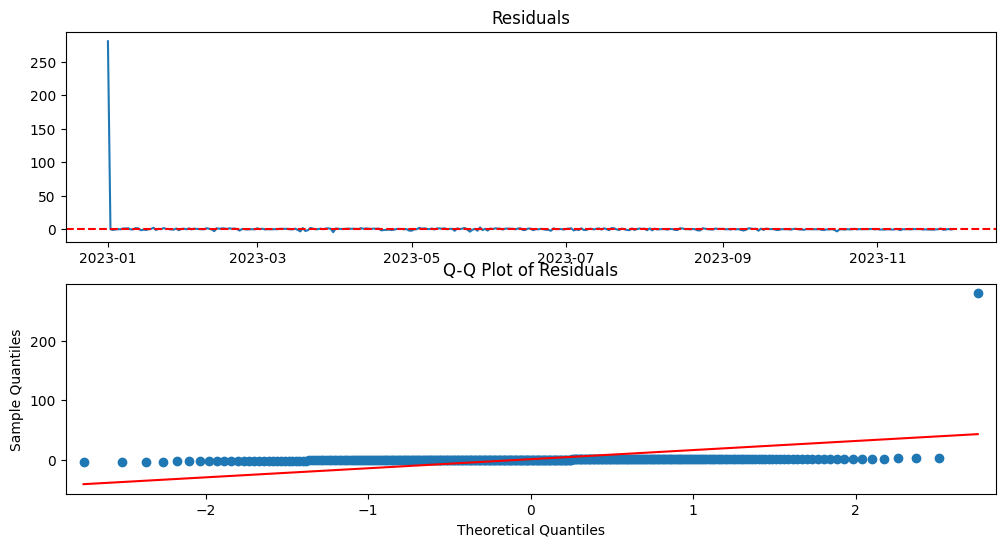

C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE for drought_index: 1.2743352545957908e-09


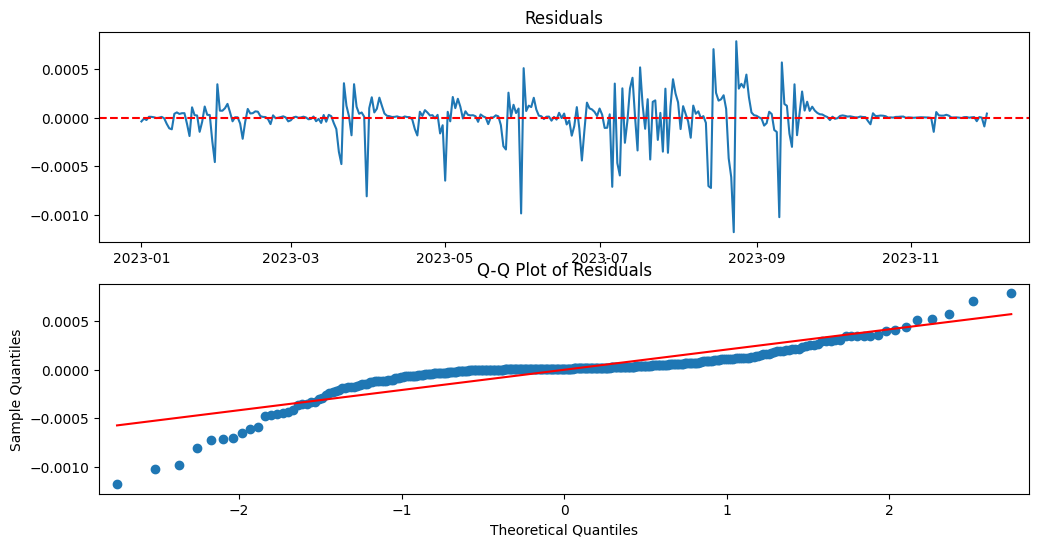

All models have been evaluated successfully.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import joblib
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = 'new_dataset.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Convert valid_time to datetime
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Set valid_time as index
data.set_index('valid_time', inplace=True)

# Resampling to daily frequency and taking the mean (adjust as needed)
daily_data = data.resample('D').mean()

# Function to perform diagnostics and predictions
def evaluate_arima_model(data, target_variable, order, test_size):
    # Split data into train and test sets
    train, test = data[:-test_size], data[-test_size:]

    # Fit ARIMA model
    model = ARIMA(train[target_variable], order=order)
    model_fit = model.fit()

    # Save the model
    joblib.dump(model_fit, f'{target_variable}_model.pkl')

    # Predictions
    predictions = model_fit.forecast(steps=test_size)
    
    # Calculate MSE
    mse = mean_squared_error(test[target_variable], predictions)
    print(f"MSE for {target_variable}: {mse}")

    # Residual analysis
    residuals = model_fit.resid
    plt.figure(figsize=(12, 6))
    
    # Residual plot
    plt.subplot(2, 1, 1)
    plt.plot(residuals)
    plt.title('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    
    # Q-Q plot
    plt.subplot(2, 1, 2)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    return model_fit

# 1. Storm Event Prediction
storm_model_fit = evaluate_arima_model(daily_data, 'tp', order=(5, 1, 0), test_size=30)

# 2. Heat Index Prediction
# Calculate Humidity from dew point using an approximation formula
daily_data['humidity'] = 100 * (np.exp((17.625 * daily_data['d2m']) / (243.04 + daily_data['d2m'])) /
                                  (np.exp((17.625 * daily_data['t2m']) / (243.04 + daily_data['t2m']))))
daily_data['heat_index'] = (daily_data['t2m'] * 9/5) + 32 + (0.5 * (1 - daily_data['humidity'] / 100) *
                          ((daily_data['t2m'] * 9/5) + 32 - 58))
daily_data['heat_index'] = (daily_data['heat_index'] - 32) * 5/9  # Convert back to Celsius
heat_index_model_fit = evaluate_arima_model(daily_data, 'heat_index', order=(5, 1, 0), test_size=30)

# 3. Climate Pattern Detection
climate_model_fit = evaluate_arima_model(daily_data, 't2m', order=(5, 1, 0), test_size=30)

# 4. Drought Index Prediction
daily_data['drought_index'] = daily_data['e'] - daily_data['tp']  # Simplified drought index calculation
drought_model_fit = evaluate_arima_model(daily_data, 'drought_index', order=(5, 1, 0), test_size=30)

print("All models have been evaluated successfully.")
